In [1]:
import osmnx as ox
import networkx as nx
import igraph as ig
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('./share_data/day_1_15_5_0', names=['D', 'O', 'no_use_time', 'share_ot', 'share_dt'])

In [3]:
len(data)

1631130

In [4]:
def change_type(x):
    try:
        y = int(x)
        return y
    except:
        # print(x)
        return -1

In [5]:
data['new_D'] = data['D'].apply(change_type)
data['new_O'] = data['O'].apply(change_type)

In [6]:
new_data = data[~((data['new_D'] == -1) | (data['new_O'] == -1))]
len(data) - len(new_data), len(new_data)

(8, 1631122)

In [7]:
new_data = new_data.drop_duplicates(subset=['new_D', 'new_O'])
len(new_data)

1618116

In [8]:
len(set(new_data['new_D']) | set(new_data['new_O']))

137886

In [9]:
def get_seconds(x):
    return pd.Timedelta(x).total_seconds()

In [10]:
new_data['no_use_time'] = new_data['no_use_time'].apply(get_seconds).astype('int32')

In [11]:
G = nx.DiGraph()
G.add_weighted_edges_from([(O, D, weight) for O, D, weight in zip(new_data['new_O'], new_data['new_D'], new_data['no_use_time'])])

In [12]:
G.number_of_nodes()

137886

In [13]:
# 拆出来的新点用原始点的字符串
new_edges = []
left, right = [], []
for edge in G.edges():
    edge_end = str(edge[1])
    new_edge = (edge[0], edge_end)
    new_edges.append(new_edge)
    left.append(edge[0])
    right.append(edge_end)

In [14]:
# 构建二分图（有向的）
new_G = nx.DiGraph()
new_G.add_nodes_from(left, bipartite=0)
new_G.add_nodes_from(right, bipartite=1)
new_G.add_weighted_edges_from([(O, D, weight) for (O, D), weight in zip(new_edges, new_data['no_use_time'])])
nx.is_bipartite(new_G)

True

In [15]:
%%time
# 注意此处的匹配是重复了的
hm_match = nx.bipartite.hopcroft_karp_matching(new_G, left)
len(hm_match)

Wall time: 3.09 s


58526

In [16]:
%%time
# 注意此处的匹配是重复了的
match = nx.bipartite.maximum_matching(new_G, left)
len(match)

Wall time: 3.07 s


58526

In [17]:
match_dict = {k:v for k,v in match.items() if isinstance(k, int)}
len(match_dict)

29263

In [18]:
## 车辆数 —— 每找到一个匹配 即相当于将原本的两个点合成一个点（路径数就减一） 找覆盖路径就相当于合点
G.number_of_nodes() - len(match_dict)

108623

In [28]:
min_weight_match = nx.bipartite.minimum_weight_full_matching(new_G, left)
len(min_weight_match)

MemoryError: Unable to allocate 49.0 GiB for an array with shape (102089, 64418) and data type float64

In [81]:
# # 基于匹配的边获取调度行程线路, 此时假定了前面的k会时间靠前
# path = []
# route = []
# new_match_dict = match_dict.copy()
# it = [k for k in new_match_dict.keys()]
# for k in it:
#     try:
#         v = new_match_dict.pop(k)
#         new_k = int(v)
#         route.extend([k, new_k])
#         while True:
#             try:
#                 v = new_match_dict[new_k]
#                 route.append(int(v))
#                 new_v = new_match_dict.pop(new_k)
#                 # it.remove(new_k)
#                 new_k = int(new_v)
#             except:
#                 path.append(route)
#                 route = []
#                 break
#     except:
#         continue

In [19]:
# 基于匹配的边获取调度行程线路
path = [[k, int(v)] for k,v in match_dict.items()]
while True:
    o = [r[0] for r in path]
    d = [r[-1] for r in path]
    com = set(d) & set(o)
    new_route = []
    left_route = []
    right_route = []
    if com:
        for c in com:
            lf = path[d.index(c)]
            rt = path[o.index(c)]
            if lf not in (left_route + right_route) and rt not in (left_route + right_route):
                left_route.append(lf)
                right_route.append(rt)
                new_route.append(lf[:-1] + rt)
        for i in range(len(new_route)):
            path.remove(left_route[i])
            path.remove(right_route[i])
            path.append(new_route[i])
    else:
        break

In [20]:
s = 0
match_nodes = []
for r in path:
    s += (len(r) -1)
    match_nodes.extend(r)
print(len(match_dict)==s, len(path), len(set(match_nodes))==len(match_nodes))

True 24901 True


In [69]:
len(match_nodes)

54164

In [21]:
G.number_of_nodes() - len(match_nodes) + len(path) == G.number_of_nodes() - len(match_dict)

True

In [22]:
# len(set([k for k in match_dict.keys()]) | set([int(v) for v in match_dict.values()]))

In [23]:
len_route = [len(r) for r in path]
max(len_route)

8

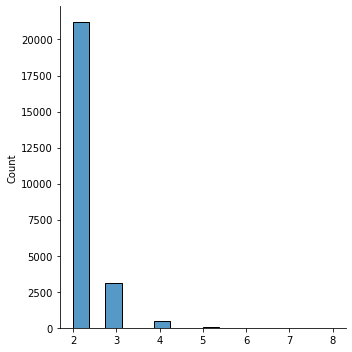

In [24]:
import seaborn as sns
# sns.displot(len_route, kde=True)
sns.displot(len_route)

可能可以调度的需求共有137886次，成功匹配后108623次（部分调度，其余仍孤立），其余是不能调度的需求

In [70]:
time_data = pd.read_csv('./data/day_data/use_day_1.csv')
time_data['pickup_datetime'] = pd.to_datetime(time_data['pickup_datetime'])
time_data['dropoff_datetime'] = pd.to_datetime(time_data['dropoff_datetime'])

In [71]:
len(time_data)

307790

In [ ]:
# 下面是有连接边的行程的起终点时间，实际上需要补充不满足调度可能性的行程，然后统一计算最大交集

In [86]:
p_time = []
d_time = []
for r in path:
    p_time.append(time_data['pickup_datetime'][r[0]])
    d_time.append(time_data['dropoff_datetime'][r[-1]])
for n in (set(G.nodes()) - set(match_nodes)):
    p_time.append(time_data['pickup_datetime'][n])
    d_time.append(time_data['dropoff_datetime'][n])

In [87]:
new_trip = pd.DataFrame([p_time, d_time]).T

In [88]:
new_trip.columns = ['pickup_datetime', 'dropoff_datetime']

In [90]:
# sum(new_trip['pickup_datetime'] == new_trip['dropoff_datetime'])

In [91]:
new_trip[(new_trip.index == 0)]

,pickup_datetime,dropoff_datetime
0,2014-01-01,2014-01-01 00:13:45


In [92]:
new_trip[~(new_trip.index == 0)]

,pickup_datetime,dropoff_datetime
1,2014-01-01 00:00:00,2014-01-01 00:11:05
2,2014-01-01 00:00:00,2014-01-01 00:09:39
3,2014-01-01 00:00:00,2014-01-01 00:15:52
4,2014-01-01 00:00:18,2014-01-01 00:12:15
5,2014-01-01 00:00:26,2014-01-01 00:16:31
...,...,...
108618,2014-01-01 19:48:00,2014-01-01 19:54:07
108619,2014-01-01 19:48:00,2014-01-01 20:01:37
108620,2014-01-01 19:48:00,2014-01-01 20:02:46
108621,2014-01-01 19:48:00,2014-01-01 19:56:12


In [93]:
i = 0
new_trip[~(new_trip.index == i)].apply(lambda x: time_inter(x['pickup_datetime'], x['dropoff_datetime'], new_trip['pickup_datetime'][i], new_trip['dropoff_datetime'][i]), axis=1)

1         1
2         1
3         1
4         1
5         1
         ..
108618    1
108619    1
108620    1
108621    1
108622    1
Length: 108622, dtype: int64

In [55]:
def time_inter(p1, d1, p2, d2):
    if d1 >= p2 or d2 >= p1:
        return 1
    else:
        return 0

In [60]:
time_inter(new_trip['pickup_datetime'][0],new_trip['dropoff_datetime'][1],new_trip['pickup_datetime'][0],new_trip['dropoff_datetime'][0])

1